In [164]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from skbio.stats.distance import permanova, anosim
from skbio import DistanceMatrix
import matplotlib.transforms as transforms
from joblib import Parallel, delayed
import seaborn as sns
from scipy.stats import f_oneway

# Quantify baseline difference using permanova

In [178]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
all_species = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

lines = []
for diet in ['Inulin','Resistant starch']:
    df_tmp = df[df.Diet==diet]
    def test_for_grouping(df_tmp, sp):
        df_tmp2 = pd.pivot_table(df_tmp[['MiceID','Day','Vendor',sp]], index=['MiceID','Vendor'], columns='Day', values=sp)[0].reset_index()
        if df_tmp2[0].max()>0.0:
            
#             # Permanova or Anosim
#             dm = pdist(np.asarray(df_tmp2[0].values).reshape(-1,1), metric='minkowski')
#             DM = DistanceMatrix(dm,list(df_tmp2.MiceID))
#             stats = anosim(DM, grouping=list(df_tmp2.Vendor), permutations=999999)
#             return stats['test statistic'],stats['p-value']

            # one way anova
            stats = f_oneway(list(df_tmp2.loc[df_tmp2.Vendor=='Beijing',0]),
                             list(df_tmp2.loc[df_tmp2.Vendor=='Guangdong',0]),
                             list(df_tmp2.loc[df_tmp2.Vendor=='Hunan',0]),
                             list(df_tmp2.loc[df_tmp2.Vendor=='Shanghai',0]))
            return stats[0],stats[1]
        else:           
            # all values are zero
            return np.NaN,np.NaN
    
    res = Parallel(n_jobs=12)(delayed(test_for_grouping)(df_tmp,sp) for sp in all_species)
    for x,y in zip(all_species, res):
        lines.append([diet, x, y[0], y[1]])
            
df_res = pd.DataFrame(lines, columns=['Diet','Bacteria','F','Pvalue'])
df_res = df_res[df_res.Pvalue.notnull()]
for diet in ['Inulin','Resistant starch']:
    df_res.loc[df_res.Diet==diet,'Pvalue_corrected'] = multipletests(df_res.loc[df_res.Diet==diet,'Pvalue'],method='fdr_bh')[1]
df_res.to_csv('baseline_difference_oneway_anova.csv', index=False)

df_res.head()

,Diet,Bacteria,F,Pvalue,Pvalue_corrected
0,Inulin,A2,2.072493,0.149956,0.405881
1,Inulin,ASF356,1.736528,0.205402,0.453107
2,Inulin,Acetatifactor,0.567803,0.645258,0.684825
3,Inulin,Acetatifactor-muris,1.428507,0.276363,0.532081
7,Inulin,Acutalibacter-muris,0.553025,0.654463,0.684825


# Compare permanova and anosim

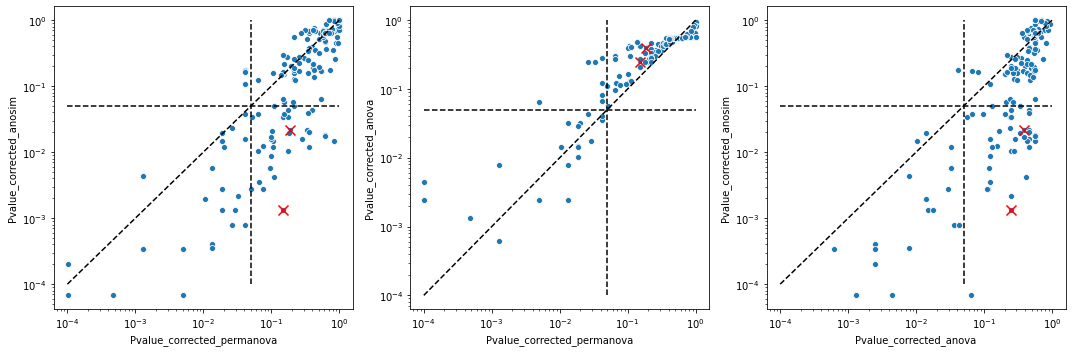

In [183]:
df_perm = pd.read_csv('baseline_difference_permanova.csv')
df_anosim = pd.read_csv('baseline_difference_anosim.csv')
df_anova = pd.read_csv('baseline_difference_oneway_anova.csv')
df_join = pd.merge(df_perm[['Diet','Bacteria','Pvalue_corrected']].rename({'Pvalue_corrected':'Pvalue_corrected_permanova'}, axis=1),
                   df_anosim[['Diet','Bacteria','Pvalue_corrected']].rename({'Pvalue_corrected':'Pvalue_corrected_anosim'}, axis=1),
                   left_on=['Diet','Bacteria'],
                   right_on=['Diet','Bacteria'],
                   how='inner'
                  )
df_join = pd.merge(df_join,
                   df_anova[['Diet','Bacteria','Pvalue_corrected']].rename({'Pvalue_corrected':'Pvalue_corrected_anova'}, axis=1),
                   left_on=['Diet','Bacteria'],
                   right_on=['Diet','Bacteria'],
                   how='inner'
                  )
df_join = df_join[df_join.Diet=='Inulin']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for k,p in enumerate([('Pvalue_corrected_permanova', 'Pvalue_corrected_anosim'),
                      ('Pvalue_corrected_permanova', 'Pvalue_corrected_anova'),
                      ('Pvalue_corrected_anova', 'Pvalue_corrected_anosim')
                     ]):
    _ = sns.scatterplot(x=p[0], y=p[1], data=df_join, ax=ax[k])
    _ = ax[k].set_xscale('log')
    _ = ax[k].set_yscale('log')
    _ = ax[k].plot([1e-4,1e0],[1e-4,1e0],'k--')
    _ = ax[k].plot([1e-4,1e0],[0.05,0.05],'k--')
    _ = ax[k].plot([0.05,0.05],[1e-4,1e0],'k--')
    _ = ax[k].scatter(df_join.loc[df_join.Bacteria=='Bacteroides-acidifaciens',p[0]],
                df_join.loc[df_join.Bacteria=='Bacteroides-acidifaciens',p[1]],
                marker='x',
                color='red',
                s=100
               )
    _ = ax[k].scatter(df_join.loc[df_join.Bacteria=='Akkermansia-muciniphila',p[0]],
                df_join.loc[df_join.Bacteria=='Akkermansia-muciniphila',p[1]],
                marker='x',
                color='red',
                s=100
               )

plt.tight_layout()

# Correlate baseline difference and time series difference

In [132]:
df_baseline_diff = pd.read_csv('baseline_difference_permanova.csv')
df_baseline_diff = df_baseline_diff[df_baseline_diff.Diet=='Inulin']
df_baseline_diff = df_baseline_diff[['Bacteria','Pvalue_corrected']]
df_baseline_diff.columns = ['Bacteria','Pvalue_baseline_corrected']

df_ts_diff = pd.read_csv('../figure4_individualized_response/inulin/individualized_response_bacteria_species_absolute_abundance_inulin_curve_only.csv', index_col=0)
df_ts_diff = df_ts_diff[['Variable','P_ind_corrected']]
df_ts_diff.columns = ['Bacteria','Pvalue_ts_corrected']

df_joint = pd.merge(df_baseline_diff, df_ts_diff, left_on=['Bacteria'], right_on=['Bacteria'], how='inner')

print('total number of species = %d'%(len(df_joint)))
print('similar baseline and similar trajectory = %d'%(len(df_joint[(df_joint.Pvalue_baseline_corrected>=0.05) & (df_joint.Pvalue_ts_corrected>=0.05)])))
print('different baseline but similar trajectory = %d'%(len(df_joint[(df_joint.Pvalue_baseline_corrected<0.05) & (df_joint.Pvalue_ts_corrected>=0.05)])))
print('different trajectory but similar baseline = %d'%(len(df_joint[(df_joint.Pvalue_baseline_corrected>=0.05) & (df_joint.Pvalue_ts_corrected<0.05)])))
print('different trajectory and different baseline = %d'%(len(df_joint[(df_joint.Pvalue_baseline_corrected<0.05) & (df_joint.Pvalue_ts_corrected<0.05)])))

total number of species = 203
similar baseline and similar trajectory = 94
different baseline but similar trajectory = 2
different trajectory but similar baseline = 81
different trajectory and different baseline = 26


In [186]:
df_joint[(df_joint.Pvalue_baseline_corrected>0.05) & (df_joint.Pvalue_ts_corrected<0.05)].head(50)

,Bacteria,Pvalue_baseline_corrected,Pvalue_ts_corrected
0,A2,0.195172,0.002269
1,ASF356,0.397393,0.000093
2,Acetatifactor,0.920532,0.002606
4,Acutalibacter-muris,0.860434,0.029172
6,Akkermansia-muciniphila,0.188751,0.000019
11,Alistipes-sp.-N15.MGS-157,0.412387,0.003753
12,Alistipes-sp.-cv1,0.361559,0.000019
13,Alloprevotella,0.356157,0.001993
16,Anaerotruncus,0.920532,0.001546
19,Anaerovorax,0.195172,0.002269


In [134]:
df_joint[df_joint.Bacteria.str.contains('Akke')]

,Bacteria,Pvalue_baseline_corrected,Pvalue_ts_corrected
5,Akkermansia,0.624149,0.184150
6,Akkermansia-muciniphila,0.188751,0.000019


In [97]:
df_baseline_diff = pd.read_csv('baseline_difference_permanova.csv')
df_baseline_diff = df_baseline_diff[df_baseline_diff.Diet=='Inulin']

In [99]:
df_baseline_diff[df_baseline_diff.Bacteria.str.contains('acid')]

,Diet,Bacteria,Pvalue,Pvalue_corrected
25,Inulin,Bacteroides-acidifaciens,0.036555,0.149707


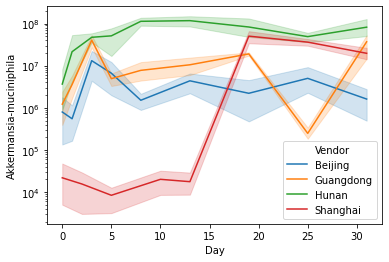

In [138]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
all_species = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

ax = sns.lineplot(x='Day', y='Akkermansia-muciniphila', hue='Vendor', data=df[df.Diet=='Inulin'])
ax.set_yscale('log')

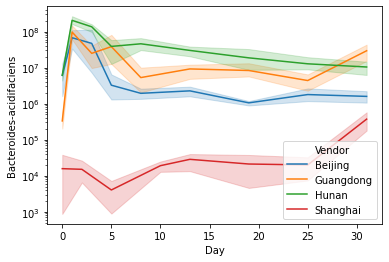

In [163]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
all_species = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

ax = sns.lineplot(x='Day', y='Bacteroides-acidifaciens', hue='Vendor', data=df[df.Diet=='Inulin'])
ax.set_yscale('log')

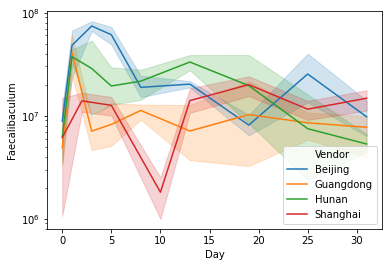

In [187]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
all_species = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

ax = sns.lineplot(x='Day', y='Faecalibaculum', hue='Vendor', data=df[df.Diet=='Inulin'])
ax.set_yscale('log')